In [1]:
# librerias
import pandas as pd
import os
import numpy as np
from scipy.stats import skew, kurtosis, kstest, norm, shapiro, t, ttest_ind, levene
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Se definen las funciones

def resumen_descriptivo(df, nombre_grupo, col='Anchura'):
    x = df[col].dropna()

    print(f"\n===== {nombre_grupo} =====")
    print(f"n                  = {x.count()}")
    print(f"Media              = {x.mean():.2f}")
    print(f"Mediana            = {x.median():.2f}")
    print(f"Moda               = {x.mode().iloc[0]:.2f}")
    print(f"Varianza           = {x.var(ddof=1):.2f}")
    print(f"Desv. típica       = {x.std(ddof=1):.2f}")
    print(f"Mínimo             = {x.min():.2f}")
    print(f"Máximo             = {x.max():.2f}")
    print(f"Q1 (25%)           = {x.quantile(0.25):.2f}")
    print(f"Q3 (75%)           = {x.quantile(0.75):.2f}")
    print(f"IQR (Q3 - Q1)      = {x.quantile(0.75) - x.quantile(0.25):.2f}")
    print(f"Asimetría (skew)   = {skew(x, bias=False):.3f}")
    print(f"Curtosis (Fisher)  = {kurtosis(x, fisher=True, bias=False):.3f}")  # 0 = normal

def ci_diff_means_equal_var(x1, x2, conf_level=0.95):
    """
    IC   -> Intervalo de Confianza
    mu i -> medias poblacionales (media real de toda la poblacion)
    IC para (mu1 - mu2) asumiendo varianzas poblacionales iguales.
    x1: muestra 1
    x2: muestra 2
    conf_level: nivel de confianza (0.90, 0.95, 0.99, ...)
    """
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)

    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    s1, s2 = x1.std(ddof=1), x2.std(ddof=1)

    # varianza combinada
    sp2 = ((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2)
    se_diff = np.sqrt(sp2 * (1/n1 + 1/n2)) # error estándar de (m1 - m2)

    df = n1 + n2 - 2
    alpha = 1 - conf_level
    t_crit = t.ppf(1 - alpha/2, df)

    diff = m1 - m2   # mu1 - mu2
    ic_low  = diff - t_crit * se_diff
    ic_high = diff + t_crit * se_diff

    return diff, ic_low, ic_high

In [3]:
# Se cargan los datos
datos = pd.read_excel('datosejercicioevaluacionanchuras.xlsx')

# Se separan los datos

datos_egipcios = datos[datos['Época histórica'] == 1]
datos_romanos = datos[datos['Época histórica'] == 2]

In [4]:
# Se obtienen variables descriptivas
resumen_descriptivo(datos_egipcios, "Predinástico temprano", col="Anchura del cráneo")
resumen_descriptivo(datos_romanos,  "Predinástico tardío",   col="Anchura del cráneo")


===== Predinástico temprano =====
n                  = 30
Media              = 131.53
Mediana            = 131.50
Moda               = 131.00
Varianza           = 0.67
Desv. típica       = 0.82
Mínimo             = 130.00
Máximo             = 134.00
Q1 (25%)           = 131.00
Q3 (75%)           = 132.00
IQR (Q3 - Q1)      = 1.00
Asimetría (skew)   = 0.692
Curtosis (Fisher)  = 1.781

===== Predinástico tardío =====
n                  = 30
Media              = 132.47
Mediana            = 133.00
Moda               = 133.00
Varianza           = 1.02
Desv. típica       = 1.01
Mínimo             = 131.00
Máximo             = 135.00
Q1 (25%)           = 132.00
Q3 (75%)           = 133.00
IQR (Q3 - Q1)      = 1.00
Asimetría (skew)   = 0.206
Curtosis (Fisher)  = 0.009


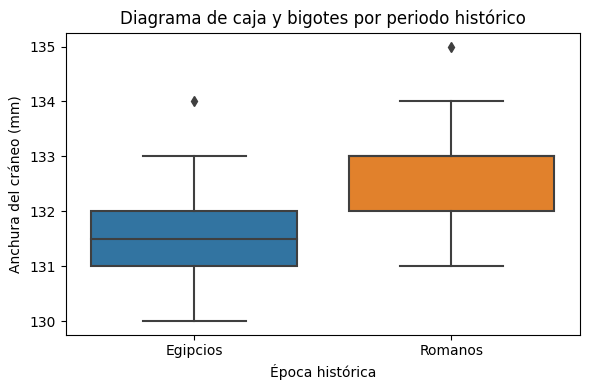

In [5]:
df = datos
df.loc[df["Época histórica"] == 1, "Época histórica"] = "Egipcios"
df.loc[df["Época histórica"] == 2, "Época histórica"] = "Romanos"

# Grafico de caja y bigotes
plt.figure(figsize=(6,4))

sns.boxplot(
    x="Época histórica",
    y="Anchura del cráneo",
    data=df
)

plt.xlabel("Época histórica")
plt.ylabel("Anchura del cráneo (mm)")
plt.title("Diagrama de caja y bigotes por periodo histórico")
plt.tight_layout()
plt.savefig("caja_bigotes.svg")

plt.show()


In [6]:
# Calculo del test KS
x_egipcios = datos_egipcios["Anchura del cráneo"].dropna()
x_romanos  = datos_romanos["Anchura del cráneo"].dropna()

# Egipcios
ks_egipcios = kstest(
    x_egipcios,
    'norm',
    args=(x_egipcios.mean(), x_egipcios.std(ddof=1)))

# Romanos
ks_romanos = kstest(
    x_romanos,
    'norm',
    args=(x_romanos.mean(), x_romanos.std(ddof=1)))

print("KS Predinástico temprano:", ks_egipcios)
print("KS Predinástico tardío :", ks_romanos)

KS Predinástico temprano: KstestResult(statistic=0.24246269818372912, pvalue=0.048862367778707116, statistic_location=131, statistic_sign=1)
KS Predinástico tardío : KstestResult(statistic=0.2349629518015396, pvalue=0.061135306356961516, statistic_location=133, statistic_sign=-1)


In [7]:
# Calcular ICs para 90%, 95% y 99%
for conf in [0.90, 0.95, 0.99]:
    diff, lo, hi = ci_diff_means_equal_var(x_egipcios, x_romanos, conf_level=conf)
    print(f"Nivel {conf*100:.0f}% -> diferencia media (época 1 - época 2) = {diff:.3f}")
    print(f"IC {conf*100:.0f}%: [{lo:.3f}, {hi:.3f}]\n")

Nivel 90% -> diferencia media (época 1 - época 2) = -0.933
IC 90%: [-1.330, -0.537]

Nivel 95% -> diferencia media (época 1 - época 2) = -0.933
IC 95%: [-1.408, -0.459]

Nivel 99% -> diferencia media (época 1 - época 2) = -0.933
IC 99%: [-1.565, -0.302]



In [8]:
# Test de Levene para igualdad de varianzas
stat_lev, p_lev = levene(x_egipcios, x_romanos)
print("Levene stat =", stat_lev, "p-value =", p_lev)

Levene stat = 0.6194926568758352 p-value = 0.434440377333167


In [9]:
t_equal, p_equal = ttest_ind(x_egipcios, x_romanos, equal_var=True)
print("t-test (varianzas iguales): t =", t_equal, "p =", p_equal)

t-test (varianzas iguales): t = -3.93544640665054 p = 0.0002247813295717879
